# Resources used:

### general sources
* [data source to obtain extra data](https://awt.cbp.gov/Specs.html)

* [python plotly heatmap](https://plot.ly/python/heatmaps/)

* [Weighting variables](http://faculty.cas.usf.edu/mbrannick/regression/Part3/Importance.html)
* [News article1: wsj long customs](https://www.wsj.com/articles/SB10001424127887323734304578541432566205480)
* [colouring cells of a dataframe](https://kanoki.org/2019/01/02/pandas-trick-for-the-day-color-code-columns-rows-cells-of-dataframe/)

### Outlier removal: 
* [Correlation: Pearson/Spearman](https://machinelearningmastery.com/how-to-use-correlation-to-understand-the-relationship-between-variables/)
*  [Multivariate Analysis (Outlier detection)](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Anomaly_Detection_for_Dummies.ipynb?source=post_page---------------------------)
    * [Medium article](https://towardsdatascience.com/anomaly-detection-for-dummies-15f148e559c1)
* [PyOD Tutorial (Outlier detection)](https://www.analyticsvidhya.com/blog/2019/02/outlier-detection-python-pyod/)
* [Understanding Outliers](https://stats.stackexchange.com/questions/200534/is-it-ok-to-remove-outliers-from-data/200923)
* [Denisty Based Algorithms for Outlier Detection](https://towardsdatascience.com/density-based-algorithm-for-outlier-detection-8f278d2f7983)
* [PyOD documentation](https://pyod.readthedocs.io/en/latest/index.html#)
* [Understanding Outliers](https://stats.stackexchange.com/questions/114214/finding-outliers-on-a-scatter-plot)

### Data set source
* [Airport Wait Times](https://awt.cbp.gov/)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
import datetime
from collections import OrderedDict
from scipy import stats
import corner
from sklearn.preprocessing import MinMaxScaler

from matplotlib.pyplot import figure
from IPython.display import HTML


plt.style.use('seaborn')
%matplotlib inline

# Exploratory Data Analysis

### Cleaning and creating new features
* create new columns: 
    - add year, month, day, Day_of_week, and actual passengers columns using python datetime
    - the actual passengers column is Actual = Total - Excluded
    - Metric: Efficiency 1 =   (Average Wait time * Actual Passengers) / Booths
* fix columns to correct format and naming
* make sure data is consistent by checking the sum of all different wait times with `total - excluded`

* What are some things to note about this metric? 
    * Metric: Efficiency1 misses out on the specific wait times since it uses average wait times
    * The specific wait times are not considered such as 0-15, 16-30... 
    * It is importnat to consider the specific wait times since people tend to have bad experiences when wait time is longer
    * Korean researchers published the first airline specific research into measuring the impact of delays on passenger sentiment and found that sentiment does change in terms of longer delays, which makes me feel that this goes the same for customs and can be even more stressful in certain situations at customs. 

    * The drawbacks are clear to us since the use of average wait time does not include specify the specific wait times. The sentiment of an individual waiting for 0-15 minutes is very different from a person waiting for an hour or more. This will not necessarily be a great measure when trying to introduce tactics to minimize wait time. We'd rather let everyone be waiting a minimal amount of time since the minimal amount of time may not affect an individual's sentiment as much. Both the passenger side should be considered when optimizing efficiency
    
    * There are many things not considered such as the flight size and number of flights that come in during the period of time
    * What are some advantages? This metric is fairly simple to calculate and understand. The efficiency metric essentially means that the `average wait time * total passengers = total wait time`. This total wait time is then divided by the booths, which indicates the amount of time spent for each flight at one booth. This would be easier for Custom border patrol to optimize since the scheduling of booths can be changed more easily. 
    
* Note: 
    * It is good for further research to include a separate analysis for Non U.S. Citizen vs U.S. Citizens
    * as well as including a separate analysis for global entry and mobile passport cases if data is recorded down. 
    
### In this particular EDA we will explore the 2017 - 2018 data set to find trends and particular times where the custom border patrols are not performing well and suggest solutions to improve on this.
* Potential questions to answer:     
    * What time is the Custom Boarder Patrol most and least efficient? 
    * Change over the years in terms of efficiency? 
    * What are some suggested solutions to help optimize efficiency? 
    * what are some ways to improve this metric? 


 # Import data and create new features

In [2]:
df = pd.read_csv('AirportWaitTimes_new.csv')
df['Date_new'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date_new'].dt.year
df['Month'] = df['Date_new'].dt.month
df['Day'] = df['Date_new'].dt.day
df['Day_of_week'] = df['Date_new'].dt.weekday

# By Total Passengers we do not use the total column but the Total - excluded since not
# everyone is included in the wait time calculation according to the data description
df['Actual'] = df['Total']-df['Excluded']



# we may want to exclude having zeros in the denominator 
# This will cause the metric: Average Wait Time x Total Passengers / Booths to become inf.
# Another reason to do this is that it does not make sense to me that there are 0 Booths
# But this may require further knowledge of understanding how CBP booth works 

# Also note that there is average wait time = 0 in the data set 
# this may be that the average wait time is actually less than a minute
# this situation appears in only 6 observations and that these observations 
# are also the ones that have booths = 0

df = df[(df['Booths'] != 0)]

df['Total Time'] = df['Average Wait Time']*df['Actual']

# Create our Efficiency (KPI/Metirc) 
df['Metric:Efficiency1'] = (df['Total Time'])/df['Booths']
df = df.reset_index(inplace = False, drop = True)
df.head()

,Airport,Terminal,Date,Hour,Average Wait Time,Max Wait Time,0-15,16-30,31-45,46-60,...,Flights,Booths,Date_new,Year,Month,Day,Day_of_week,Actual,Total Time,Metric:Efficiency1
0,SFO,Terminal A,2017-01-01,0000 - 0100,7,17,111,8,0,0,...,1,8,2017-01-01,2017,1,1,6,119,833,104.125000
1,SFO,Terminal A,2017-01-01,0100 - 0200,11,24,111,52,0,0,...,1,8,2017-01-01,2017,1,1,6,163,1793,224.125000
2,SFO,Terminal A,2017-01-01,0900 - 1000,20,56,397,260,178,50,...,6,26,2017-01-01,2017,1,1,6,885,17700,680.769231
3,SFO,Terminal A,2017-01-01,1000 - 1100,19,50,328,96,131,38,...,5,27,2017-01-01,2017,1,1,6,593,11267,417.296296
4,SFO,Terminal A,2017-01-01,1100 - 1200,24,41,24,112,36,0,...,2,23,2017-01-01,2017,1,1,6,172,4128,179.478261


### Import first quarter 2010 to 2016 and 2019 data set to help impute missing data
#### Why is there missing data in some places? 
* Over the course of the day, incoming flights may not occur for extended periods of time due to variable flight arrival patterns. Wait times are calculated in hourly time intervals for all flights arriving at the airport/terminal shown. The CBP Airport Wait Times report displays only those time intervals during which at least one flight arrival was recorded. If no flights arrived during a particular time interval, that time interval will not appear in the report!

In [3]:
# Import data
df1 = pd.read_csv('2010.csv')
df2 = pd.read_csv('2011.csv')
df3 = pd.read_csv('2012.csv')
df4 = pd.read_csv('2013.csv')
df5 = pd.read_csv('2014.csv')
df6  = pd.read_csv('2015.csv')
df7 = pd.read_csv('2016.csv')
df8 = pd.read_csv('2019.csv')
# this is just 2017-2018 data


frames = [df1, df2, df3, df4, df5, df6, df7, df8]
df_full = pd.concat(frames, sort =False)
df_full = df_full.reset_index(inplace = False, drop = True)

In [4]:
df_full.head()

,Airport,Terminal,Date,Hour,Average Wait Time,Max Wait Time,0-15,16-30,31-45,46-60,61-90,91-120,120 plus,Excluded,Total,Flights,Booths
0,SFO,Terminal A,1/1/2010,0700 - 0800,9,21,197,17,0,0,0,0,0,7,221,1,26
1,SFO,Terminal A,1/1/2010,0900 - 1000,19,36,211,403,54,0,0,0,0,23,691,3,24
2,SFO,Terminal A,1/1/2010,1000 - 1100,24,58,128,299,188,3,0,0,0,20,638,2,26
3,SFO,Terminal A,1/1/2010,1200 - 1300,17,28,133,225,0,0,0,0,0,21,379,1,24
4,SFO,Terminal A,1/1/2010,1300 - 1400,11,27,227,42,0,0,0,0,0,9,278,1,34


In [5]:
len(df_full)

9196

In [6]:
# additional data set that will help us imput values
df_full['Date_new'] = pd.to_datetime(df_full['Date'])
df_full['Year'] = df_full['Date_new'].dt.year
df_full['Month'] = df_full['Date_new'].dt.month
df_full['Day'] = df_full['Date_new'].dt.day
df_full['Day_of_week'] = df_full['Date_new'].dt.weekday  
df_full['Actual'] = df_full['Total'] - df_full['Excluded']

# create total time column 


convert_day = {0: 'Monday', 1: 'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
# we can use .map(convert_day) to convert Day_of_week 
# the day of the week now but it is not practical to work with so lets do that later 0,1,2,3,4,5,6 is 
df_full = df_full[(df_full['Booths'] != 0)]
df_full['Total Time'] = df_full['Average Wait Time']*df_full['Actual']

df_full['Metric:Efficiency1'] = (df_full['Total Time'])/df_full['Booths']

df_full = df_full.reset_index(inplace = False, drop = True)

## Scatter plot of the Total Passenger x Average Wait Time vs Number of booths
* Scatter plot probably indicates inefficiency
* This is because when we observe the correlation value we see that this positive relationship either linear/nonlinear isn't very strong. (rouhgly around 0.5)
* We can use the scatter plot to remove outliers, which we will discuss later

## Ideal situation
* Supposedly More booths should be asociated with more total time. 
* How do we fix this? We can try to reassign booths and create a stronger positive relationship.
* Notice that the possible maximum amount of booths is 37 so we can use this as a limit when we reassign booths


In [7]:
print('Maximum Number of Booths 2017-2018 first quareter: ', df['Booths'].max())
print('Maximum Number of Booths in 2010-2016 and 2019 first quareter: ', df_full['Booths'].max())

Maximum Number of Booths 2017-2018 first quareter:  29
Maximum Number of Booths in 2010-2016 and 2019 first quareter:  37


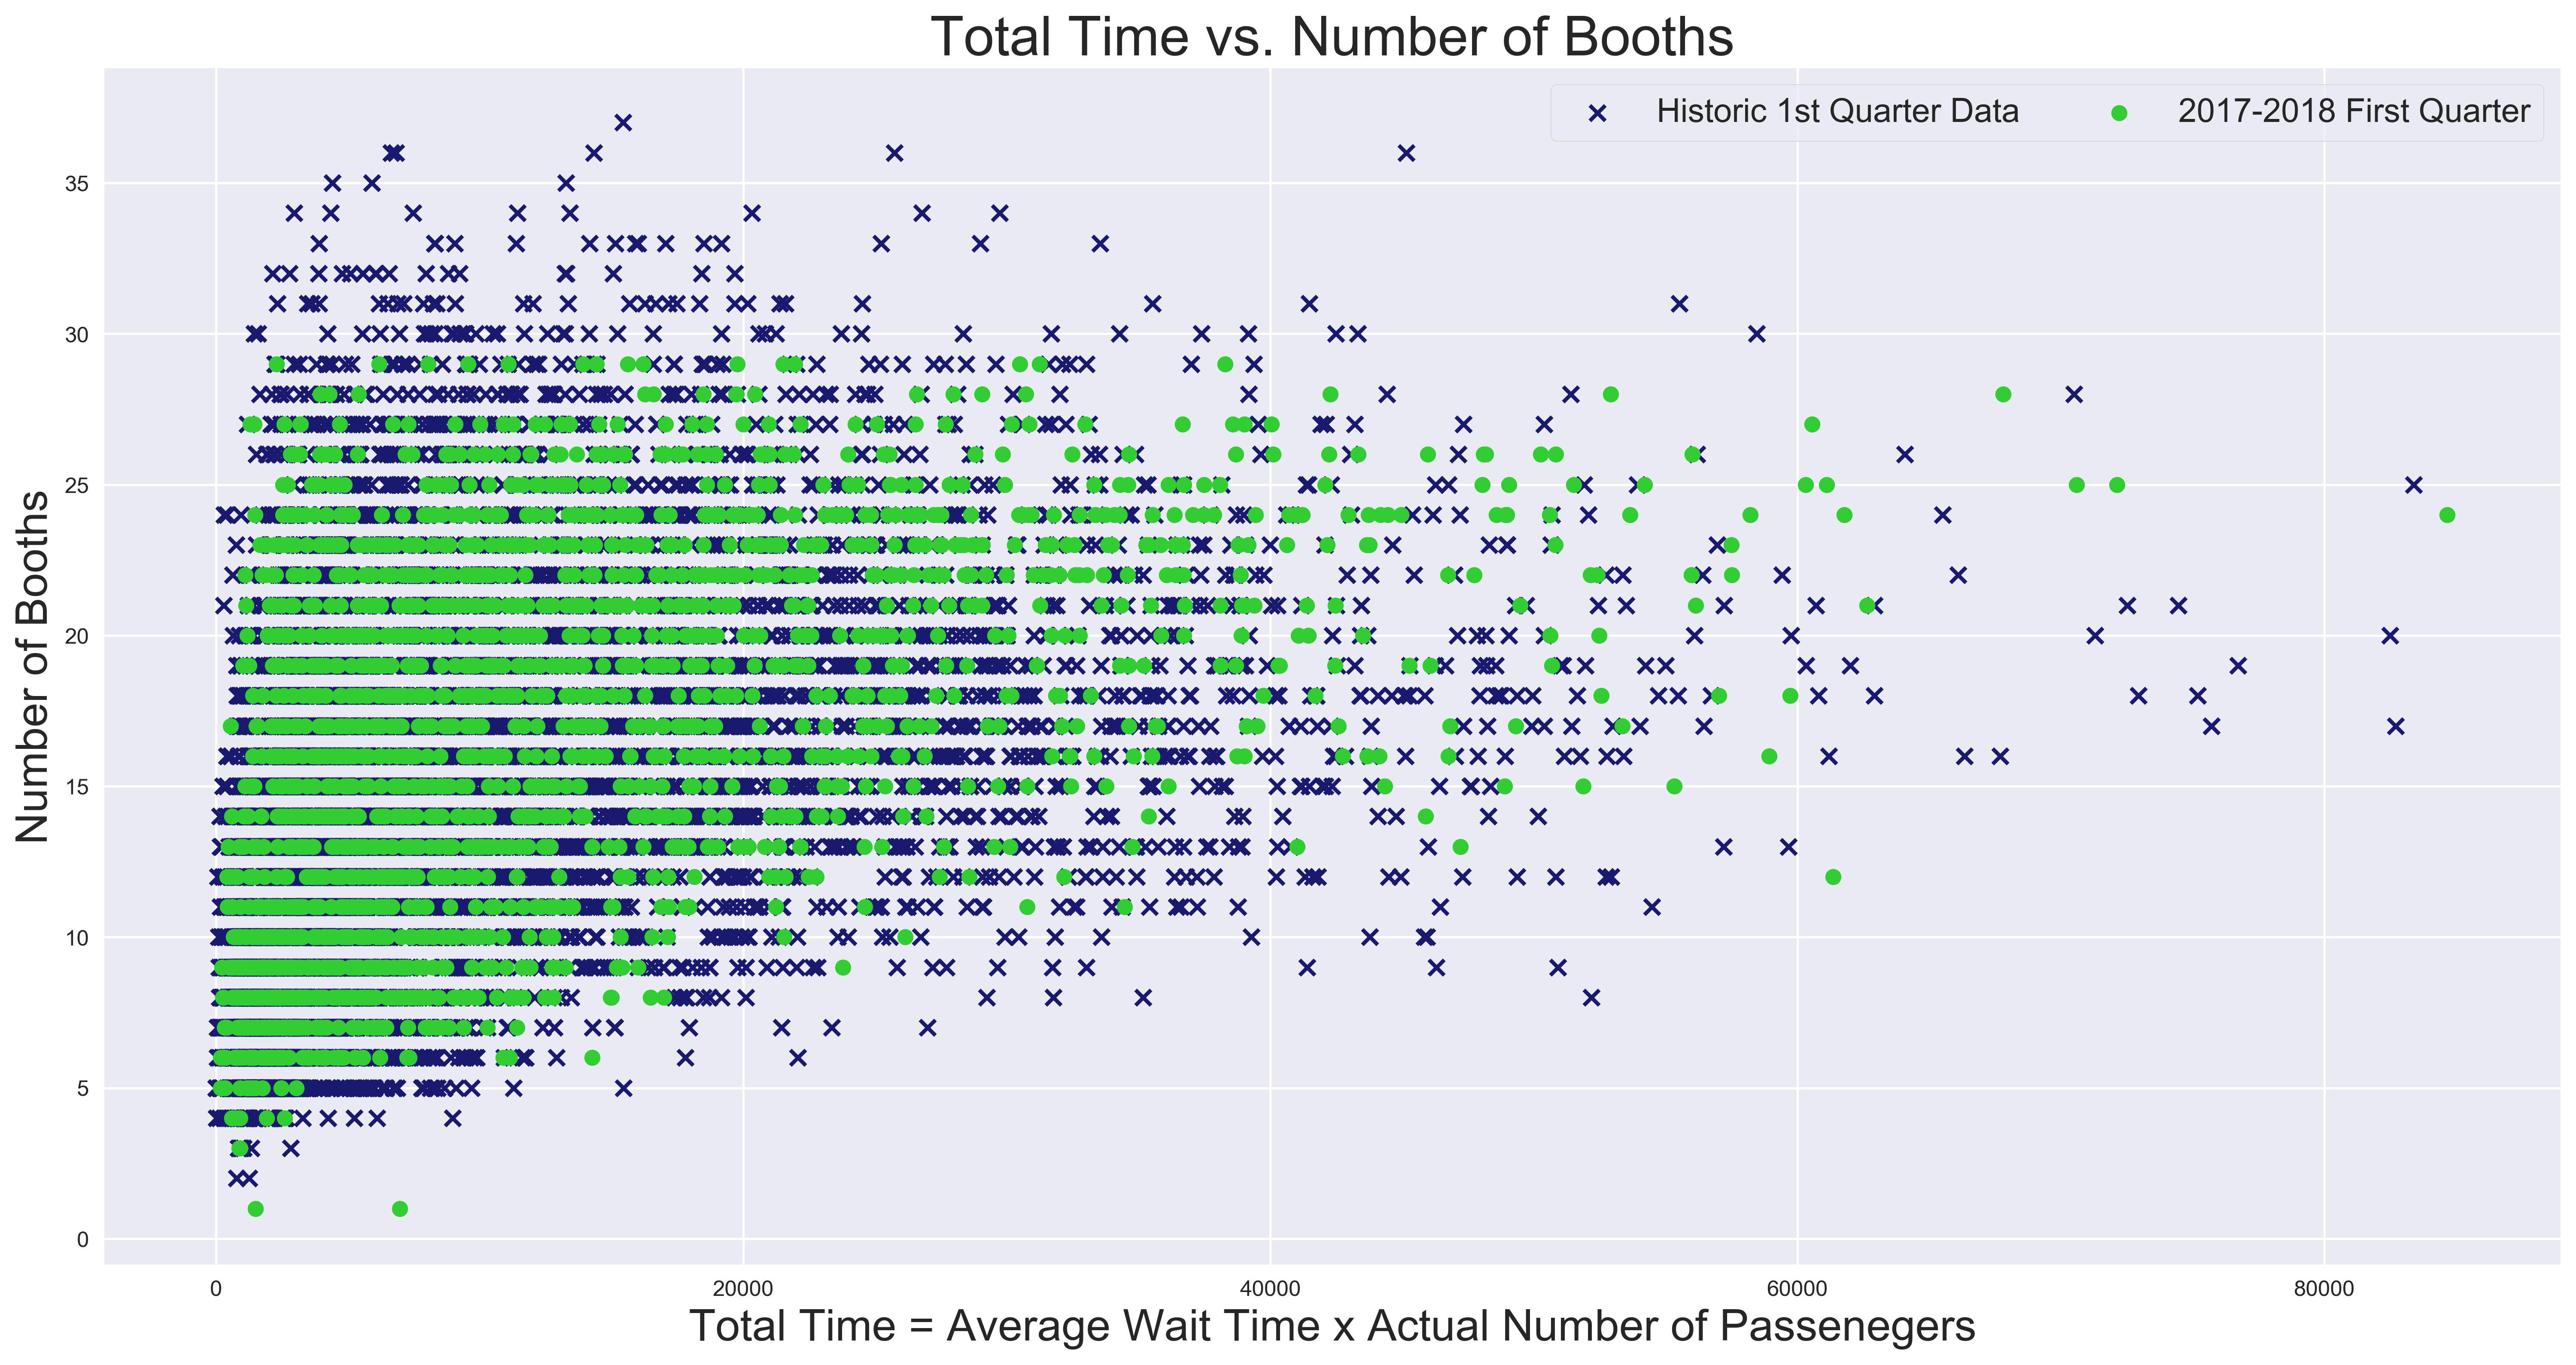

In [8]:
figure(num=1, figsize=(20, 10), dpi=369, facecolor='w', edgecolor='k')
fig1 = plt.scatter(df_full['Total Time'],df_full['Booths'],  marker='x', color='midnightblue')
fig2 = plt.scatter(df['Average Wait Time']*df['Actual'],df['Booths'],  marker='o', color='limegreen')


plt.xlabel("Total Time = Average Wait Time x Actual Number of Passenegers", fontsize=20)
plt.ylabel("Number of Booths", fontsize = 20)
plt.title("Total Time vs. Number of Booths", fontsize = 25) 

plt.legend((fig1,fig2),
           ('Historic 1st Quarter Data', '2017-2018 First Quarter' ),
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           fontsize=15,frameon=True)

plt.show()

### Lets remove some inconsistent records, we see that the values in wait times 0-15, 16-30, 31-45....etc should sum up to the total amount subtracted by the exclude amount of people. If this isn't true there is an inconsistency of data and that would make our evaluations not as accurate.

* lets try to remove these records and decide whether it is necessary and if we would have too much information losss after this process
* After observing the sum_passengers, we can be sure that they are in fact all consistent

In [9]:
# we will create a new column to check this and name it as sum_passengers
df['sum_passengers'] = df['0-15']+df['16-30']+ df['31-45']+ df['46-60']+ df['61-90']+ df['91-120']+ df['120 plus'] +df['Excluded']

df[df['sum_passengers'] != df['Total']].index
# They are all matching so we dont have uninformative observations

Int64Index([], dtype='int64')

# Efficiency Chart

In [10]:
# We separte into 3 situations 
# 2017 and 2018 together, 2017 alone, 2018 alone
year2017 = df[df['Date_new'].dt.year == 2017]
year2018 = df[df['Date_new'].dt.year == 2018]

In [11]:
efficiency_table2017 = round(year2017.groupby(['Hour','Day_of_week']).mean()['Metric:Efficiency1']).unstack()

# we can see that there are NaN values in the table 
# as mentioned this is becuase The CBP Airport Wait Times report displays only those time intervals 
# during which at least one flight arrival was recorded. If no flights 
# arrived during a particular time interval, that time interval will not appear in the report!
# we can also use efficiency_table2017.isnull() to check the locations where True appears
efficiency_table2017.style.highlight_null(null_color='green')

Day_of_week,0,1,2,3,4,5,6
Hour,,,,,,,
0000 - 0100,183,260,131,227,307,270,186
0100 - 0200,810,348,476,nan,213,322,314
0200 - 0300,nan,nan,650,nan,nan,nan,nan
0800 - 0900,503,1535,1124,567,904,779,716
0900 - 1000,1050,954,1042,830,608,852,543
1000 - 1100,590,839,732,1104,696,982,519
1100 - 1200,477,836,321,438,287,278,387
1200 - 1300,943,807,772,856,594,823,562
1300 - 1400,840,845,581,622,864,507,607


### Do we impute these Nan Values or what else can we do? 
* After observing the 2017-2018 data set we find that there is only 1 observation in the entire ata set that is in the 2 to 3 am (0200 - 0300) inteval 
* I was not sure if this is a specific case so we look back to the historical data and we can observe only 4 observations in this particular interval, this is 0.045% of the entire historical data. 
* It's quite interesting that over the past 9 years there was only 5 days where the customs were operating at 2-3am in the first quarter. This makes imputing impossible due to the lack of data.
* After doing some research and some assumptions we can drop this entire row since usual airlines dont fly around this time.
* There are many reasons for this:
    * people don't like flying late
    * destination time difference (inconvenience, lack of transportation, etc)
    * Not many facilities in the airport would be operating 
    * and many more 
    
### Impute
* We only impute the NaN value in the 1 to 2 am (0100 - 0200) interval
* There are 27 records in the historical data for this intervaldata, although this is only 1.2 % of the entire data set our reason to keep this is because in 2017 - 2018 there are actually 18 records. 
* Over 9 years there are 27 records and in 2017 - 2018 first quarter data accounts for 18 records. This 3 times as much as the norma amount that would happen and may mean importance. 

## Lets impute

In [13]:
# lets use this to impute the NaN in efficiency_table2017
med = round(df_full[(df_full['Hour'] == '0100 - 0200')]['Metric:Efficiency1'].median())

# we already explained why we dont consider 2 to 3 am interval so we drop the row 
efficiency_table2017 = efficiency_table2017.drop('0200 - 0300', axis = 0)
efficiency_table2017.fillna(med, inplace =True)
efficiency_table2017

Day_of_week,0,1,2,3,4,5,6
Hour,,,,,,,
0000 - 0100,183.0,260.0,131.0,227.0,307.0,270.0,186.0
0100 - 0200,810.0,348.0,476.0,219.0,213.0,322.0,314.0
0800 - 0900,503.0,1535.0,1124.0,567.0,904.0,779.0,716.0
0900 - 1000,1050.0,954.0,1042.0,830.0,608.0,852.0,543.0
1000 - 1100,590.0,839.0,732.0,1104.0,696.0,982.0,519.0
1100 - 1200,477.0,836.0,321.0,438.0,287.0,278.0,387.0
1200 - 1300,943.0,807.0,772.0,856.0,594.0,823.0,562.0
1300 - 1400,840.0,845.0,581.0,622.0,864.0,507.0,607.0
1400 - 1500,395.0,844.0,445.0,587.0,527.0,479.0,226.0


In [14]:
efficiency_tabledf = round(df.groupby(['Hour','Day_of_week']).mean()['Metric:Efficiency1']).unstack()
efficiency_tabledf = efficiency_tabledf.drop('0200 - 0300', axis = 0)
efficiency_tabledf.fillna(med, inplace =True)
efficiency_tabledf

Day_of_week,0,1,2,3,4,5,6
Hour,,,,,,,
0000 - 0100,262.0,363.0,270.0,254.0,511.0,676.0,226.0
0100 - 0200,485.0,364.0,476.0,219.0,249.0,315.0,262.0
0800 - 0900,519.0,1187.0,790.0,690.0,555.0,651.0,513.0
0900 - 1000,977.0,922.0,898.0,831.0,832.0,1131.0,796.0
1000 - 1100,610.0,685.0,658.0,839.0,668.0,871.0,556.0
1100 - 1200,431.0,561.0,299.0,413.0,259.0,354.0,374.0
1200 - 1300,1115.0,898.0,1031.0,1148.0,835.0,995.0,902.0
1300 - 1400,795.0,783.0,669.0,845.0,782.0,813.0,842.0
1400 - 1500,686.0,804.0,488.0,877.0,738.0,541.0,568.0


In [15]:
efficiency_table2018 = round(year2018.groupby(['Hour','Day_of_week']).mean()['Metric:Efficiency1'].unstack())
# we dont need the line below since there arent any 0200 - 0300 records to even consider
# efficiency_table2018 = efficiency_table2018.drop('0200 - 0300', axis = 0)
efficiency_table2018.fillna(med, inplace =True)
efficiency_table2018

Day_of_week,0,1,2,3,4,5,6
Hour,,,,,,,
0000 - 0100,367.0,501.0,479.0,282.0,1126.0,920.0,335.0
0100 - 0200,160.0,414.0,219.0,219.0,357.0,302.0,109.0
0800 - 0900,529.0,664.0,456.0,813.0,381.0,396.0,473.0
0900 - 1000,904.0,891.0,725.0,832.0,1131.0,1438.0,1162.0
1000 - 1100,658.0,543.0,541.0,496.0,601.0,750.0,675.0
1100 - 1200,379.0,311.0,275.0,386.0,225.0,424.0,362.0
1200 - 1300,1302.0,982.0,1312.0,1416.0,1147.0,1168.0,1343.0
1300 - 1400,750.0,720.0,773.0,1087.0,685.0,1068.0,1097.0
1400 - 1500,888.0,786.0,521.0,1141.0,929.0,593.0,767.0


## Identifying the most efficient and least efficient times
* We will use a highlighted table along with a heatmap to observe such trends and locations

### Note: I suggest using a wider range to define whats efficient. There is quite a lot of uncertainty when deciding whether or not if an interval is actually efficient (Remember that there are quite a few disadvantages to the Efficiency metric we are using)
* Why do we pick the 25% percentile and 75% percentile? 
    * This is because 25% percentile reduces the mean average wait time to around 15 minutes, this is quite nice considering the over all historical data suggests that the average wait time is around 22 minutes. 
    * For the 75% percentile the mean average wait time increases to 32 minutes and this really not great and no one want to wait this long

In [16]:
good_efficiency = np.percentile(efficiency_tabledf.values.reshape(1,-1), 25)
print("Mean of Average Wait Time for 25% percentile", df[df['Metric:Efficiency1'] <=good_efficiency]['Average Wait Time'].mean())
print("Mean of Booths for 25% percentile", df[df['Metric:Efficiency1'] <=good_efficiency]['Booths'].mean())
bad_efficiency = np.percentile(efficiency_tabledf.values.reshape(1,-1), 75)
print("Mean of Average Wait Time for 75% percentile", df[df['Metric:Efficiency1'] >= bad_efficiency]['Average Wait Time'].mean())
print("Mean of Booths for 75% percentile", df[df['Metric:Efficiency1'] >= bad_efficiency]['Booths'].mean())
print(np.percentile(efficiency_tabledf.values.reshape(1,-1), 25))
print(np.percentile(efficiency_tabledf.values.reshape(1,-1), 75))
print(np.percentile(efficiency_tabledf.values.reshape(1,-1), 99))
print(np.percentile(efficiency_tabledf.values.reshape(1,-1), 1))

Mean of Average Wait Time for 25% percentile 15.440320962888666
Mean of Booths for 25% percentile 14.746238716148445
Mean of Average Wait Time for 75% percentile 31.8781512605042
Mean of Booths for 75% percentile 17.613445378151262
476.5
833.5
1599.0
229.25


## Create a highlighting function for highlighting the percentiles on the groupby table 

In [17]:
def highlight_min(s):    
    is_min = s <= np.percentile(efficiency_tabledf.values.reshape(1,-1), 25) # efficiency score of roughly 375
    return ['background-color: orange' if v else '' for v in is_min]

def highlight_max(s):    
    is_max = s >= np.percentile(efficiency_tabledf.values.reshape(1,-1), 75)
    return ['background-color: red' if v else '' for v in is_max]

def max_val(s):    
    is_max = s >= np.percentile(efficiency_tabledf.values.reshape(1,-1), 99)
    return ['background-color: cyan' if v else '' for v in is_max]

def min_val(s):    
    is_max = s <= np.percentile(efficiency_tabledf.values.reshape(1,-1), 1)
    return ['background-color: lightgreen' if v else '' for v in is_max]

# Overall 2017 to 2018  Efficiency Table and Heatmap
* Note we named the 2017 to 2018 efficienct tables as efficiency_tabledf
* 2017 as efficiency_table2017
* 2018 as efficiency_table2018 

In [18]:
efficiency_tabledf.rename(columns = convert_day).style.apply(highlight_min).apply(highlight_max).apply(min_val).apply(max_val)



Day_of_week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Hour,,,,,,,
0000 - 0100,262,363,270,254,511,676,226
0100 - 0200,485,364,476,219,249,315,262
0800 - 0900,519,1187,790,690,555,651,513
0900 - 1000,977,922,898,831,832,1131,796
1000 - 1100,610,685,658,839,668,871,556
1100 - 1200,431,561,299,413,259,354,374
1200 - 1300,1115,898,1031,1148,835,995,902
1300 - 1400,795,783,669,845,782,813,842
1400 - 1500,686,804,488,877,738,541,568


# Lets also observe the heatmap 

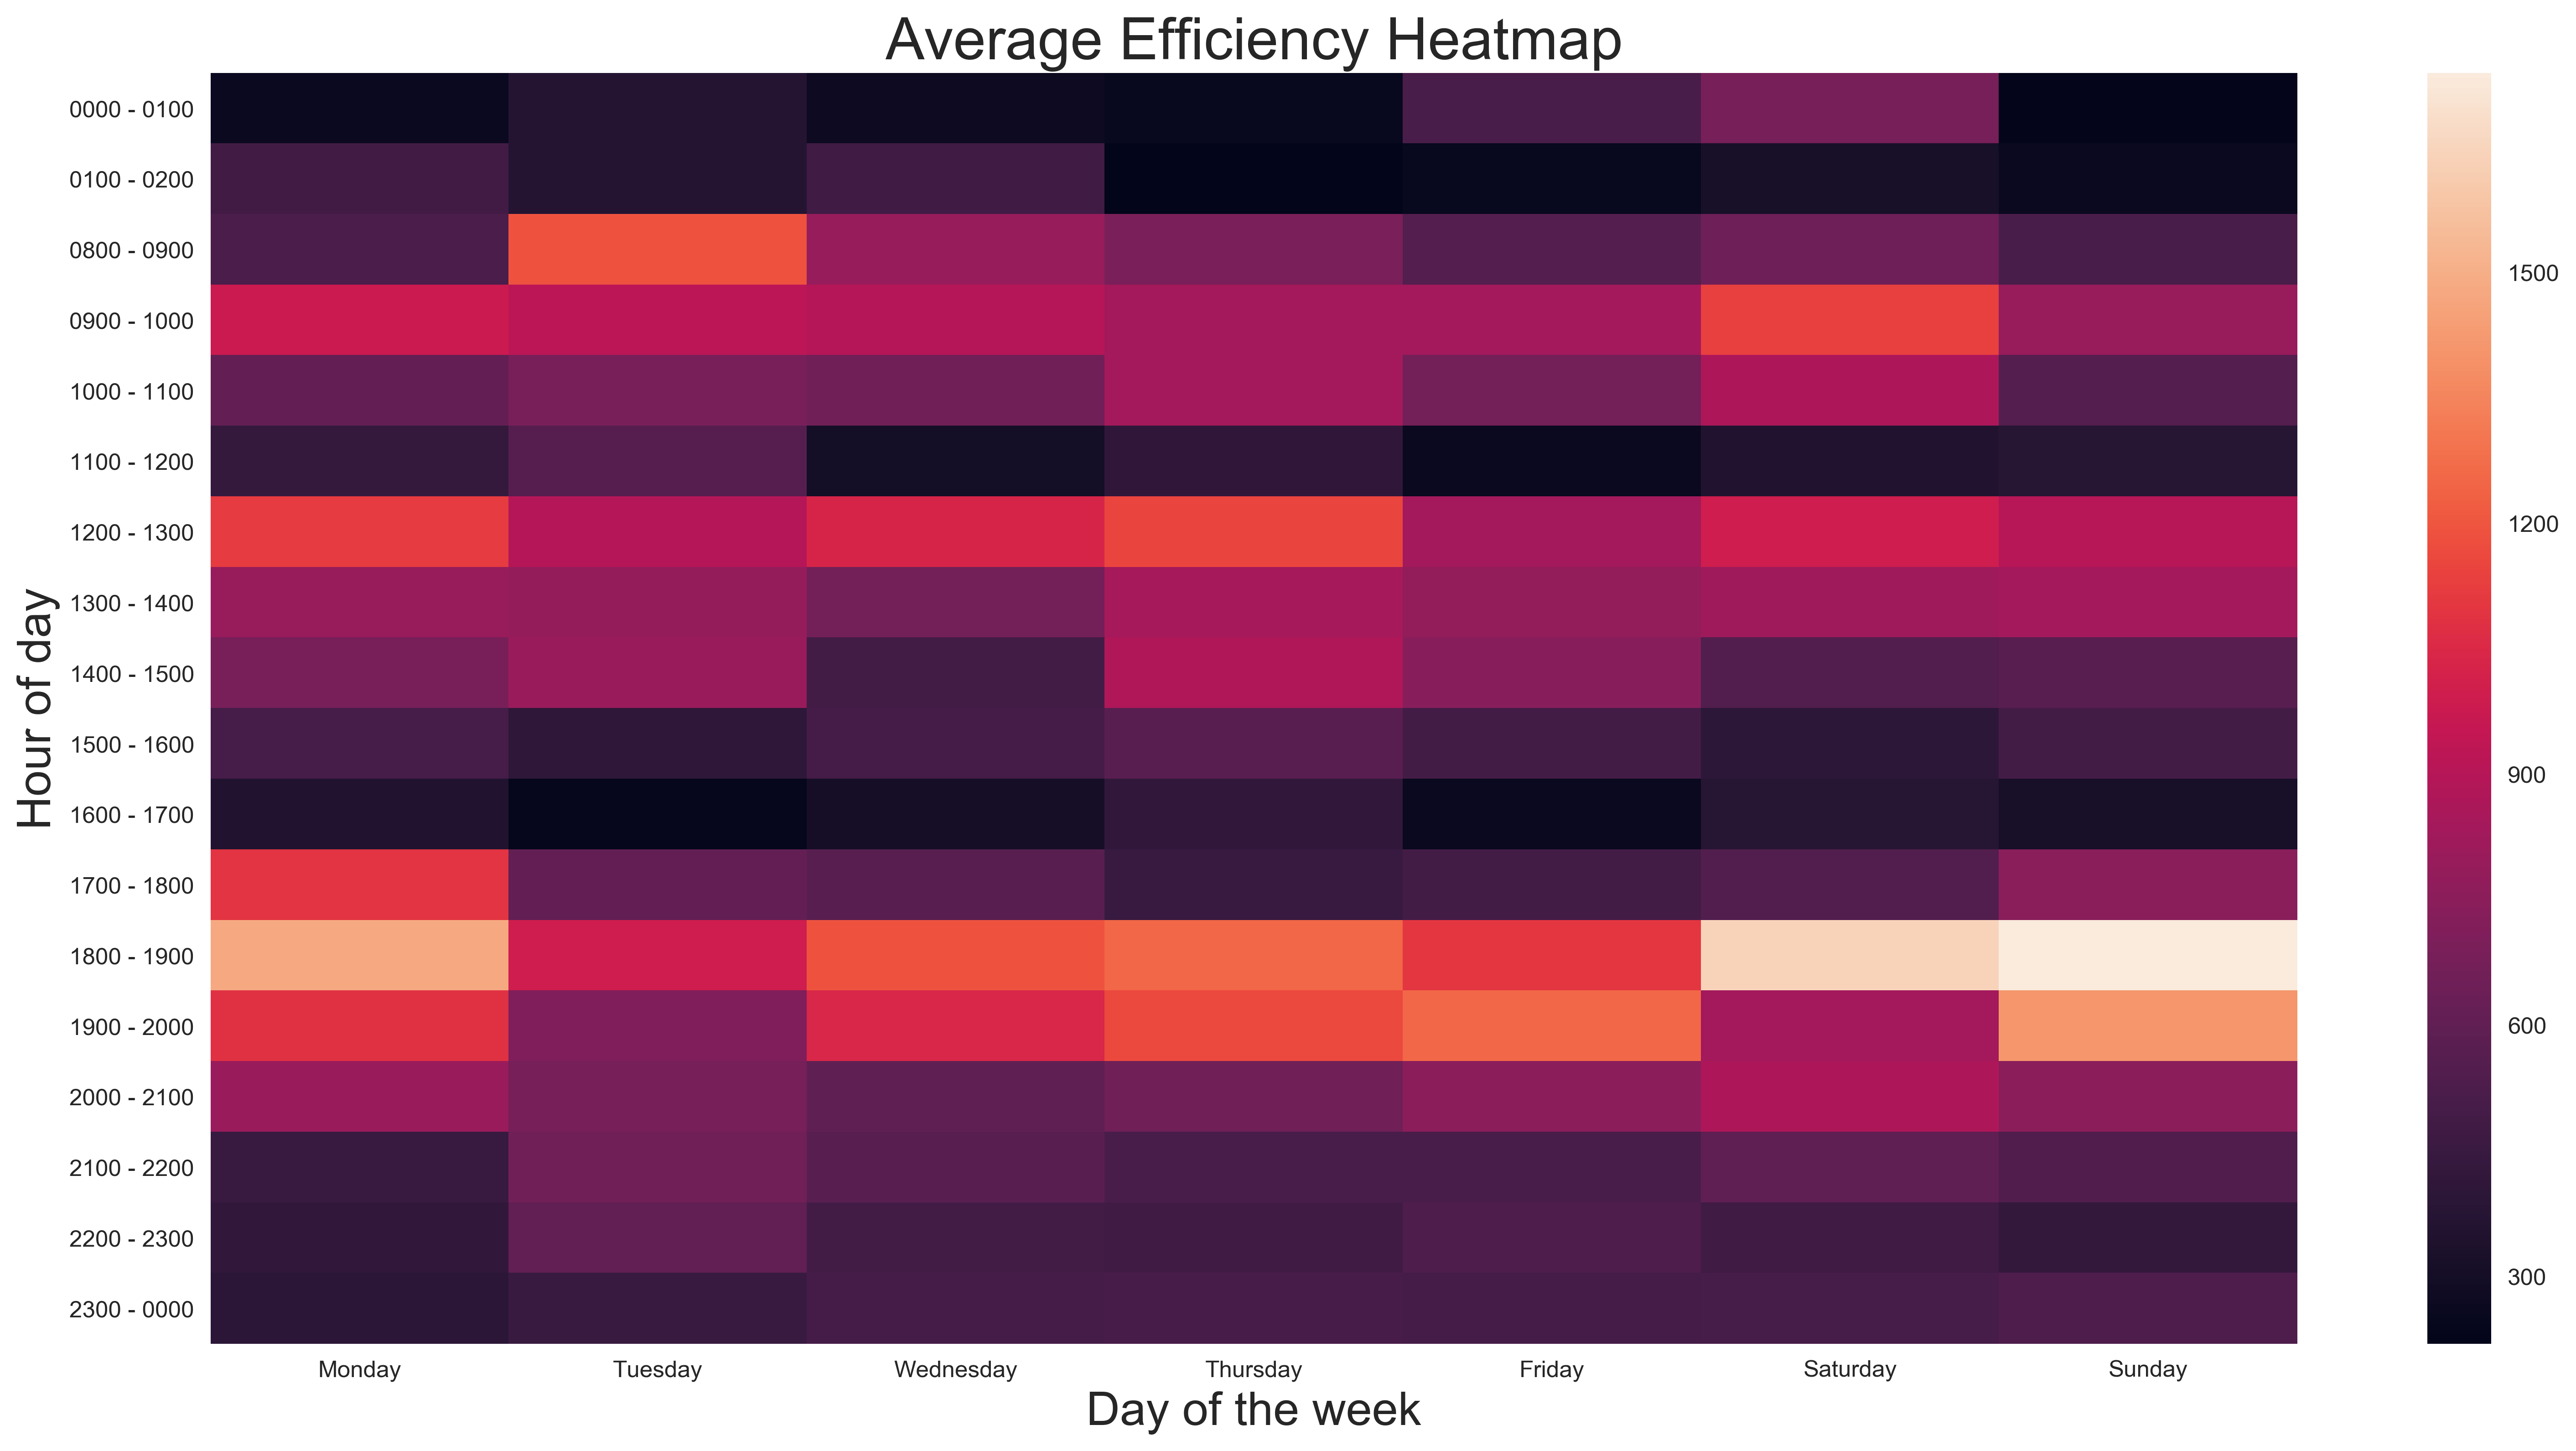

In [19]:
figure(num=1, figsize=(20, 10), dpi=369, facecolor='w', edgecolor='k')
heatmap_efficiency_df = efficiency_tabledf.rename(columns = convert_day)
#'Day_of_week', fill_value=0)
ax = plt.axes()
sns.heatmap(heatmap_efficiency_df, ax=ax)

ax.set_title('Average Efficiency Heatmap', fontsize=25)
ax.set_xlabel("Day of the week", fontsize = 20)
ax.set_ylabel("Hour of day", fontsize = 20)

plt.show()

# 2017 Efficiency Table and Heatmap

In [20]:
efficiency_table2017.rename(columns = convert_day).style.apply(highlight_min).apply(highlight_max).apply(min_val).apply(max_val)

Day_of_week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Hour,,,,,,,
0000 - 0100,183,260,131,227,307,270,186
0100 - 0200,810,348,476,219,213,322,314
0800 - 0900,503,1535,1124,567,904,779,716
0900 - 1000,1050,954,1042,830,608,852,543
1000 - 1100,590,839,732,1104,696,982,519
1100 - 1200,477,836,321,438,287,278,387
1200 - 1300,943,807,772,856,594,823,562
1300 - 1400,840,845,581,622,864,507,607
1400 - 1500,395,844,445,587,527,479,226


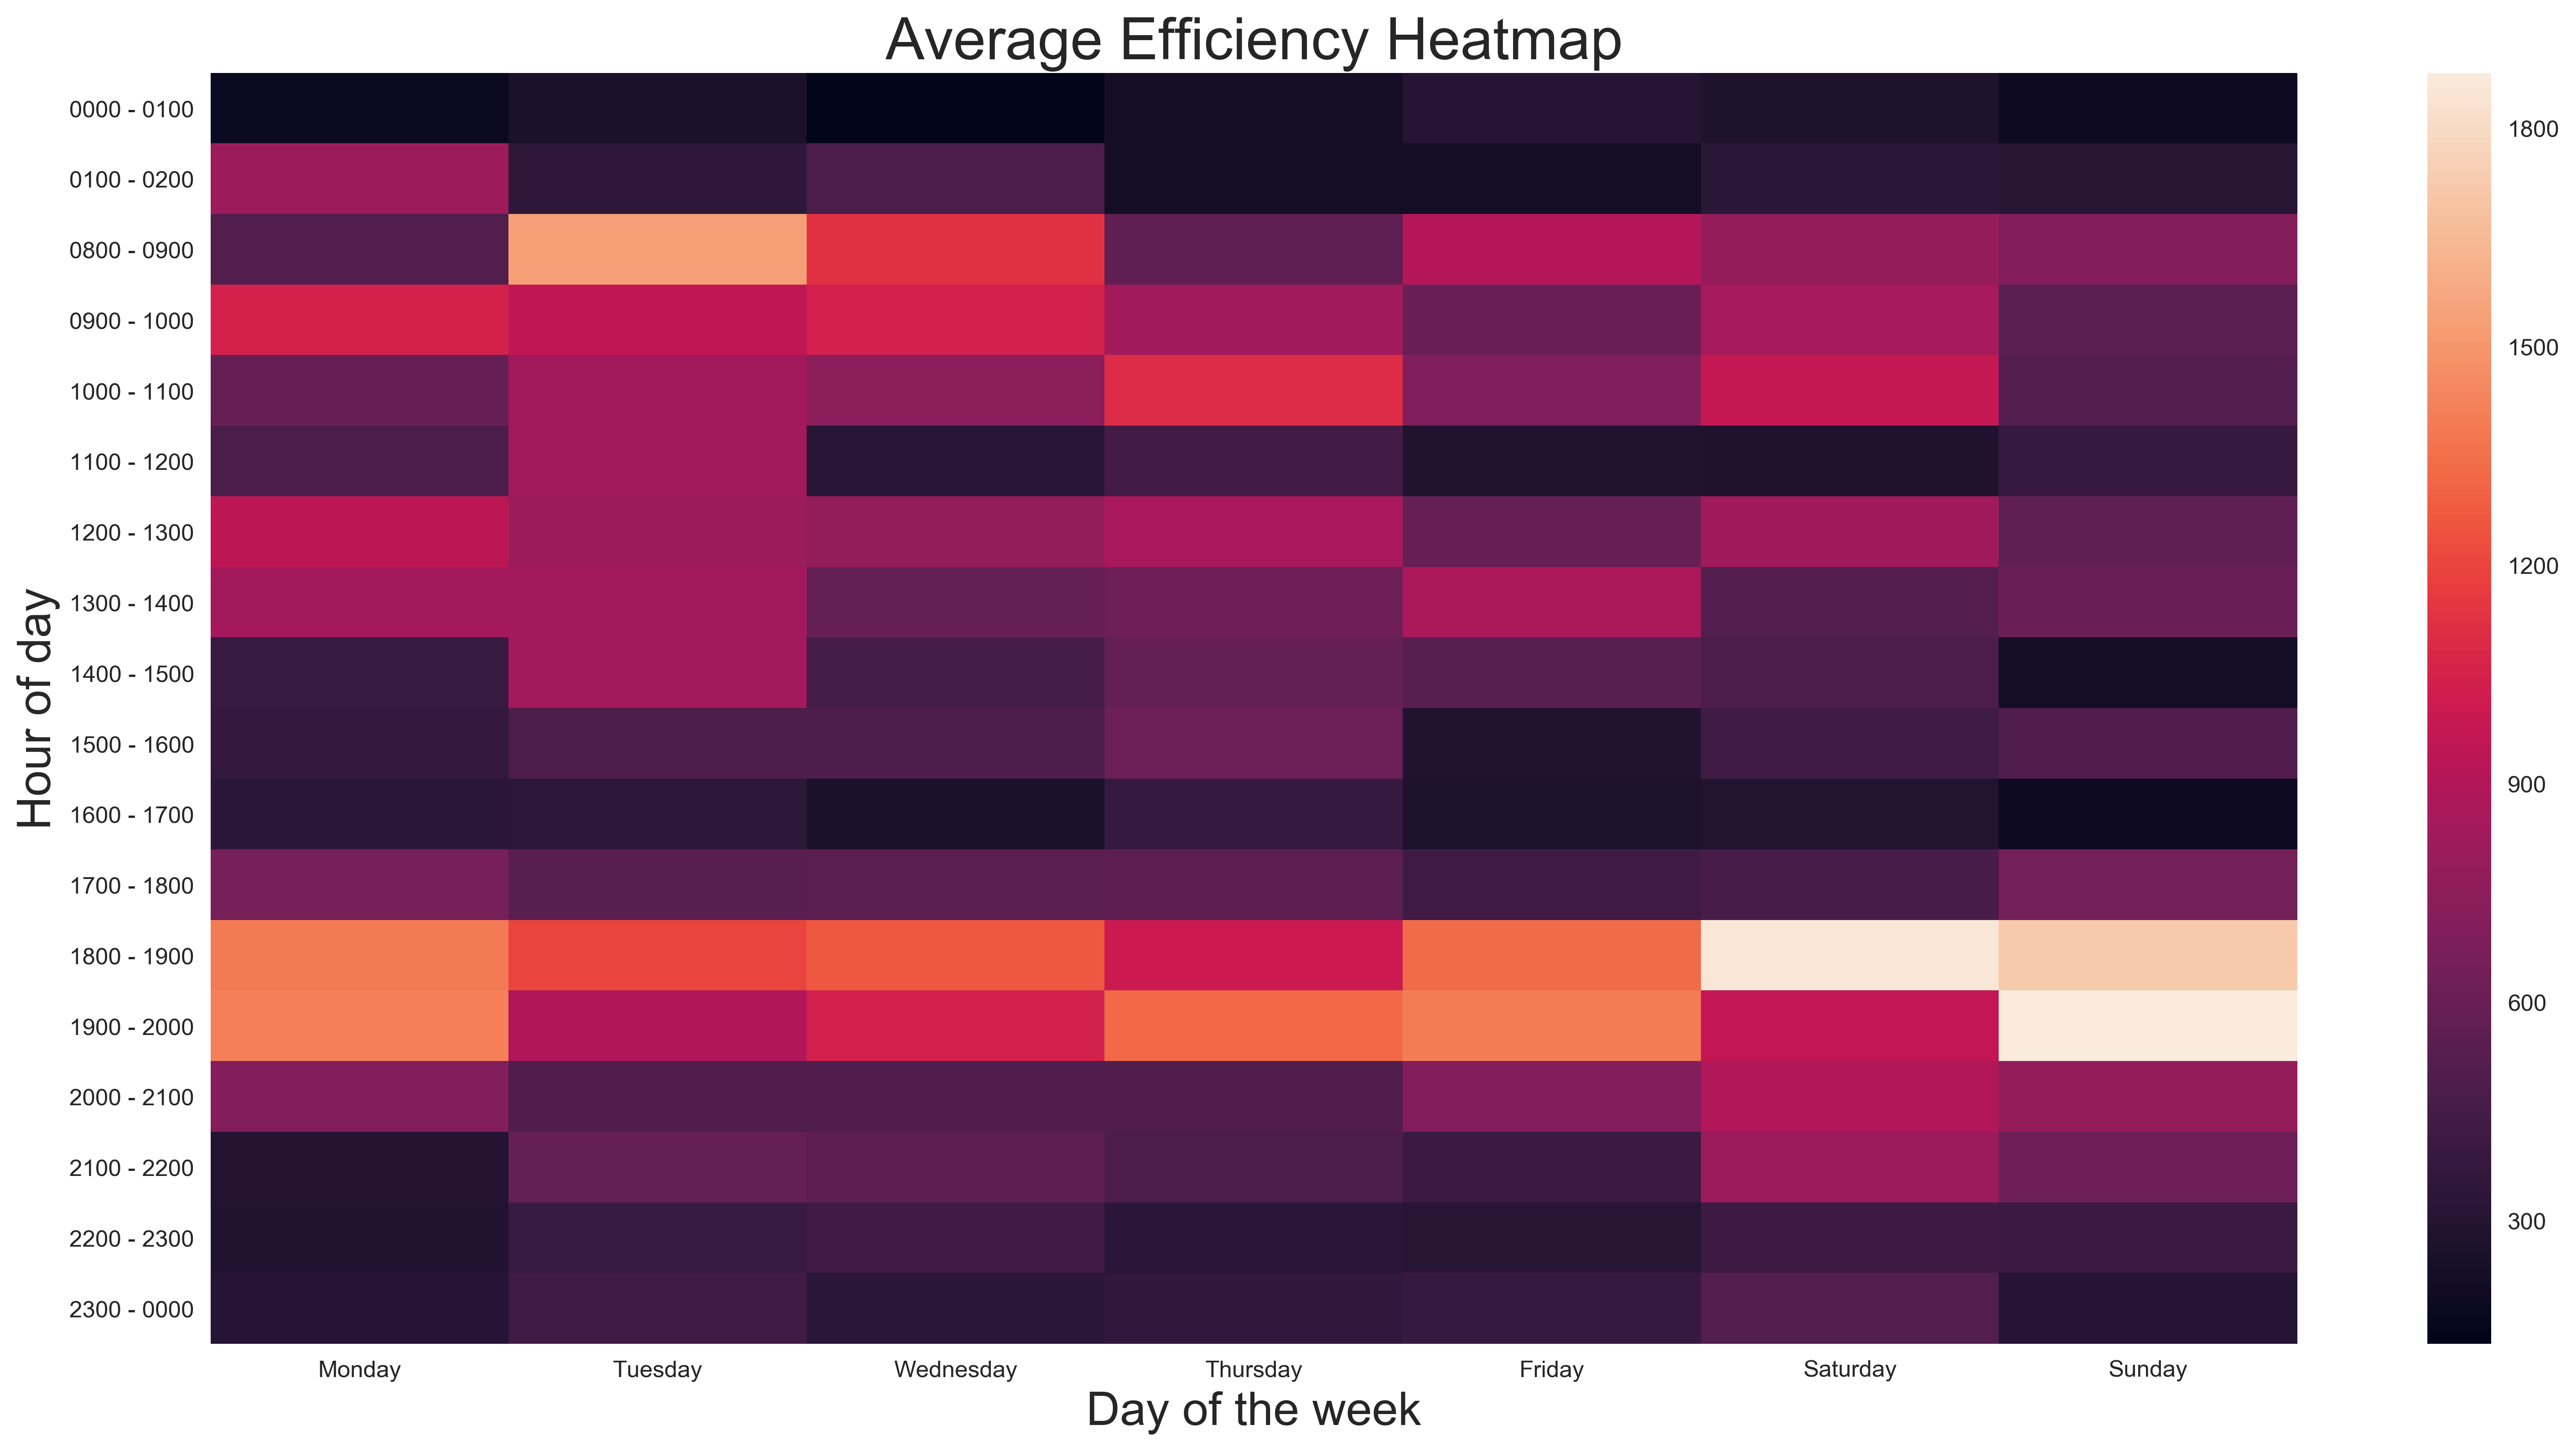

In [21]:
figure(num=1, figsize=(20, 10), dpi=369, facecolor='w', edgecolor='k')
heatmap_efficiency_2017 = efficiency_table2017.rename(columns = convert_day)

ax = plt.axes()
sns.heatmap(heatmap_efficiency_2017, ax=ax)

ax.set_title('Average Efficiency Heatmap', fontsize=25)
ax.set_xlabel("Day of the week", fontsize = 20)
ax.set_ylabel("Hour of day", fontsize = 20)

plt.show()

# 2018 Efficiency Table and Heatmap

In [22]:
efficiency_table2018.rename(columns = convert_day).style.apply(highlight_min).apply(highlight_max).apply(min_val).apply(max_val)

Day_of_week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Hour,,,,,,,
0000 - 0100,367,501,479,282,1126,920,335
0100 - 0200,160,414,219,219,357,302,109
0800 - 0900,529,664,456,813,381,396,473
0900 - 1000,904,891,725,832,1131,1438,1162
1000 - 1100,658,543,541,496,601,750,675
1100 - 1200,379,311,275,386,225,424,362
1200 - 1300,1302,982,1312,1416,1147,1168,1343
1300 - 1400,750,720,773,1087,685,1068,1097
1400 - 1500,888,786,521,1141,929,593,767


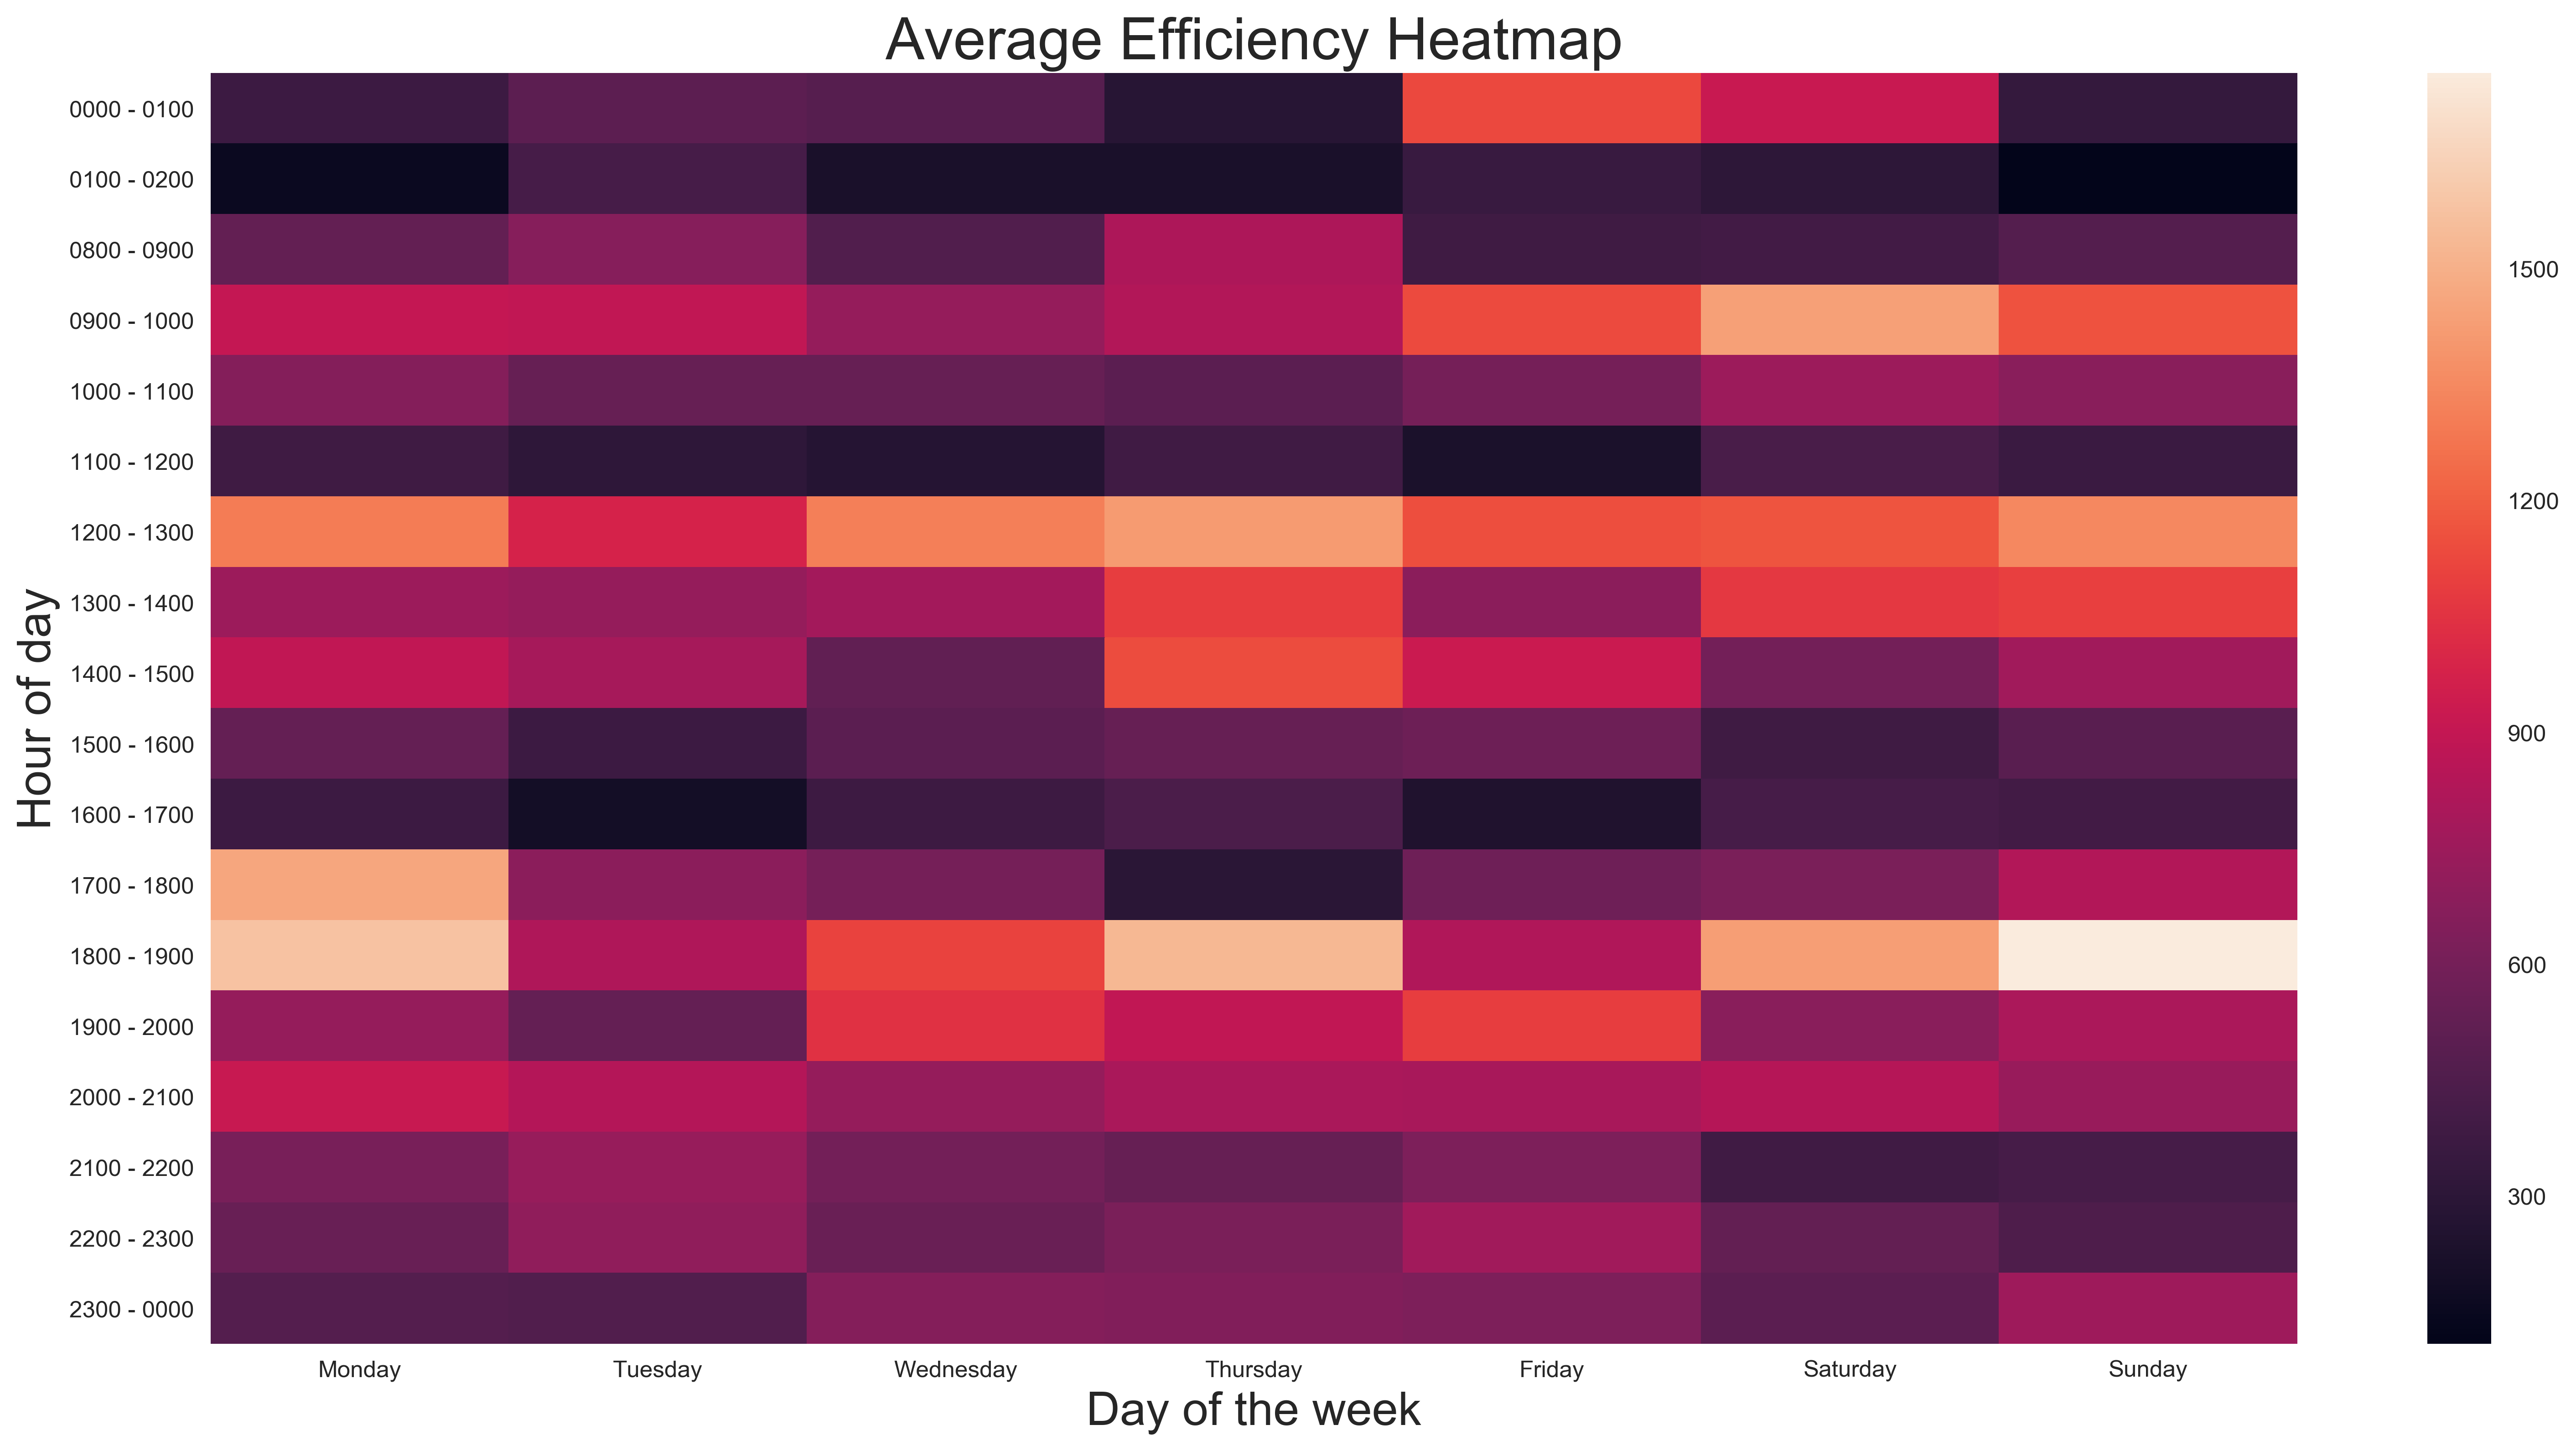

In [23]:
figure(num=1, figsize=(20, 10), dpi=369, facecolor='w', edgecolor='k')
heatmap_efficiency_2018 = efficiency_table2018.rename(columns = convert_day)

ax = plt.axes()
sns.heatmap(heatmap_efficiency_2018, ax=ax)

ax.set_title('Average Efficiency Heatmap', fontsize=25)
ax.set_xlabel("Day of the week", fontsize = 20)
ax.set_ylabel("Hour of day", fontsize = 20)

plt.show()

# Conclusion on least and most efficienct
* We see that in 2017 to 2018 theres exist clusters of efficiency
    * `12 to 2 am CBP has been very efficient for the entire week`
    * `11 to 12 pm is the next inteval that is quite efficient for the entire week`
    * `4 to 5 pm is also efficient for the entire week`
    * `just to mention that 3 to 4 pm and 10 to 12 am is also kind of acceptable mostly within the 50% percentile`  
* 2017 
    * `2017 seems much more effiicient than 2018`
    * `We see that 12 to 2 am is very efficient some even within the 1% percentile`
    * `mostly efficient from 11 to 12`
    * `4 to 5 pm is also efficient for the entire week`
    * `10 to 12 am also is efficient`
   
* So we can kind of see that the change in efficiency from 2017 to 2018 is in the interval 10 to 12 am, but we will observe it more carefully 

* Also note the light blue highlights show the most inefficient locations and the light green shows most efficient
    * `We can roughly see that 6 to 8 pm Saturday/Sunday as the most inefficient`
    * `and Sunday 12 to 1 am as most efficient (To be fair the entire 12 to 1 am is very efficient so when we are considering 3 tables it is hard to pick which one is most efficient)`
    


# Observing the difference 
* we see that in partiuclar flights from 1200 - 1500 has changed significantly in efficiency 
* if we did a sum over the rows and only considered the day of week then we notice that Thursay efficiency value increased the most from 2017 to 2018. Meaning it is not as efficient on Thursday, Wednesday, Sunday
* In addition it is much more efficient on Monday in 2018 than that of 2017
* What else have we noticed Tuesday stayed the same 

In [24]:
def highlight_min(s):    
    is_min = s <= np.percentile(delta.abs().values.reshape(1,-1), 5) # efficiency score of roughly 375
    return ['background-color: orange' if v else '' for v in is_min]

def highlight_max(s):    
    is_max = s >= np.percentile(delta.abs().values.reshape(1,-1), 85)
    return ['background-color: red' if v else '' for v in is_max]

def max_val(s):    
    is_max = s >= np.percentile(delta.abs().values.reshape(1,-1), 99)
    return ['background-color: cyan' if v else '' for v in is_max]

def min_val(s):    
    is_max = s <= np.percentile(delta.abs().values.reshape(1,-1), 1)
    return ['background-color: lightgreen' if v else '' for v in is_max]

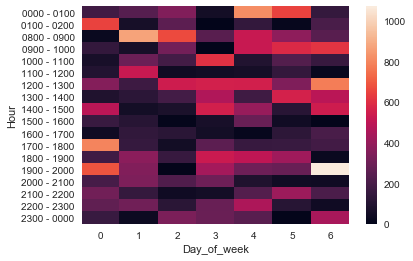

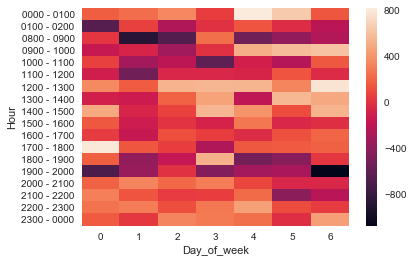

Day_of_week,0,1,2,3,4,5,6
Hour,,,,,,,
0000 - 0100,184,241,348,55,819,650,149
0100 - 0200,650,66,257,0,144,20,205
0800 - 0900,26,871,668,246,523,383,243
0900 - 1000,146,63,317,2,523,586,619
1000 - 1100,68,296,191,608,95,232,156
1100 - 1200,98,525,46,52,62,146,25
1200 - 1300,359,175,540,560,553,345,781
1300 - 1400,90,125,192,465,179,561,490
1400 - 1500,493,58,76,554,402,114,541


In [25]:
delta = efficiency_table2018-efficiency_table2017
# Note We use the absolute value function to see the change
sns.heatmap(delta.abs())
plt.show()

sns.heatmap(delta)
plt.show()
delta.abs().style.apply(highlight_max).apply(max_val)

# Proposing a new metric

* Supposedly that when people wait longer their sentiment may change from indifferent to anger
* which is why we should give weights to the wait times in particular 
    * Weights
        * 0-15: 1
        * 16-30: 2
        * 31-45: 3
        * 46-60: 4
        * 61-90: 6
        * 91-120: 8
        * 120 plus: 10
        

In [26]:
weighted = df

In [27]:
# You get penalized extremely if people wait up to 120 plus
weighted['16-30'] = weighted['16-30']*np.exp(1)
weighted['31-45'] = weighted['31-45']*np.exp(1.5)
weighted['46-60'] = weighted['46-60']*np.exp(2)
weighted['61-90'] = weighted['61-90']*np.exp(2.5)
weighted['91-120'] = weighted['91-120']*np.exp(3)
weighted['120 plus'] = weighted['120 plus']*np.exp(3.5)

In [28]:
weighted['sum_passengers'] = weighted['0-15'] + weighted['16-30'] + weighted['31-45'] + weighted['46-60'] + weighted['61-90'] + weighted['91-120'] +weighted['120 plus']



In [29]:
weighted['Metric:Efficiency2'] = (weighted['sum_passengers']*weighted['Average Wait Time']) / weighted['Booths']

In [30]:
year2017_weighted = weighted[weighted['Date_new'].dt.year == 2017]
year2018_weighted = weighted[weighted['Date_new'].dt.year == 2018]

In [31]:
efficiency_table2017_weighted = year2017_weighted.groupby(['Hour','Day_of_week']).mean()['Metric:Efficiency2'].unstack()


efficiency_table2017_weighted = efficiency_table2017_weighted.drop('0200 - 0300', axis = 0)


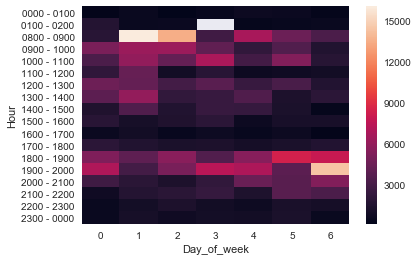

In [32]:
sns.heatmap(efficiency_table2017_weighted)
plt.show()

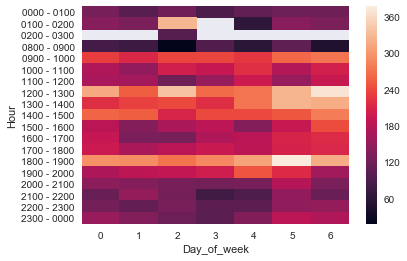

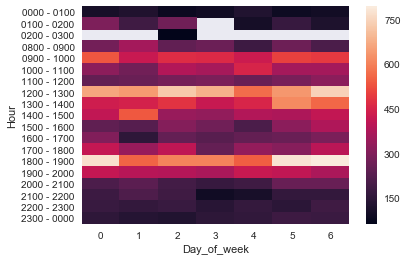

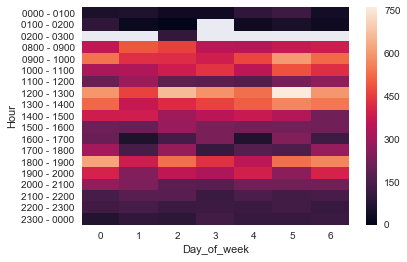

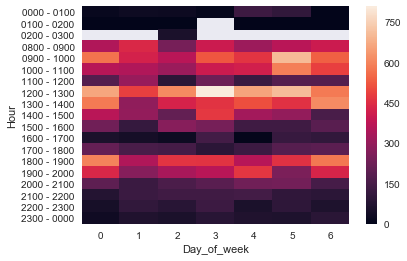

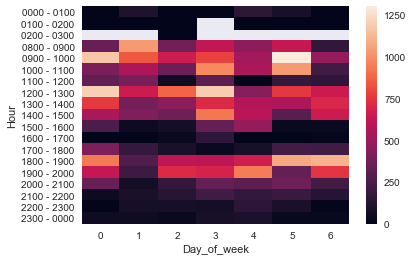

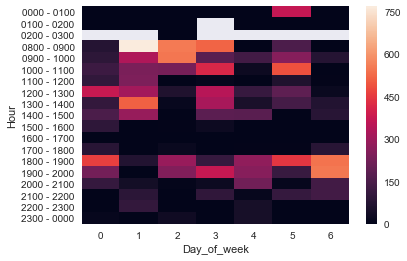

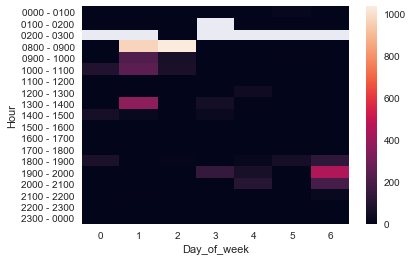

In [33]:
sns.heatmap(df.groupby(['Hour', 'Day_of_week']).mean()['0-15'].unstack())
plt.show()
sns.heatmap(df.groupby(['Hour', 'Day_of_week']).mean()['16-30'].unstack())
plt.show()
sns.heatmap(df.groupby(['Hour', 'Day_of_week']).mean()['31-45'].unstack())
plt.show()
sns.heatmap(df.groupby(['Hour', 'Day_of_week']).mean()['46-60'].unstack())
plt.show()
sns.heatmap(df.groupby(['Hour', 'Day_of_week']).mean()['61-90'].unstack())
plt.show()
sns.heatmap(df.groupby(['Hour', 'Day_of_week']).mean()['91-120'].unstack())
plt.show()
sns.heatmap(df.groupby(['Hour', 'Day_of_week']).mean()['120 plus'].unstack())
plt.show()